# Quantum Fidelity

The fidelity $F$ or the infidelity $I=1-F$ is a measure of a quantum channels
accuracy. There is a plethora of different fidelity measures and qopt offers several methods.
Here we start with the most basic examples in the absence of noise and introduce more
fidelity measures in the following sections.

Let's start with the example of a single qubit under Rabi-driving from the last notebook.

In [1]:
import numpy as np
from qopt import *

sigma_x = DenseOperator.pauli_x()
sigma_y = DenseOperator.pauli_y()
sigma_z = DenseOperator.pauli_z()

delta_omega = 0

h_ctrl = [.5 * sigma_x, .5 * sigma_y]
h_drift = [delta_omega * .5 * sigma_z]

n_time_steps = 5
total_time = 1

time_steps = (total_time / n_time_steps) * np.ones((n_time_steps, ))

control_amplitudes = np.zeros((n_time_steps, len(h_ctrl)))
control_amplitudes[:, 0] = np.pi

initial_state = DenseOperator(np.asarray([[1], [0]]))
solver = SchroedingerSolver(
    h_drift=h_drift,
    h_ctrl=h_ctrl,
    tau=time_steps,
    initial_state=initial_state
)
solver.set_optimization_parameters(control_amplitudes)

Remember that this pulse implements an $X_\pi$-rotation around the x-axis.

We start with the state infidelity which measures the overlap of the initial state with the target wave function:

\begin{align}
I_{\text{state}} = 1 - | < \psi_{\text{initial}}| \psi_{\text{final}}>|^2
\end{align}

In [2]:
state_infidelity = StateInfidelity(
    solver=solver,
    target=DenseOperator(np.asarray([[0], [1]]))
)
print("The state infidelity " +
      str(state_infidelity.costs())
      + " is 0 within the computational accuracy. ")

The state infidelity -1.3322676295501878e-15 is 0 within the computational accuracy. 


More information contains the gate fidelity, which describes the entire quantum gate and not only the action on a single initial state. We can set up the gate fidelity of this solver with the
$X_\pi$-Rotation as target. The gate fidelity (equivalent to the entanglement fidelity) $I_e$ between a quantum
channel described by a unitary evolution $U$ and a target evolution $V$ can be
calculated as Hilbert-Schmidt vector product:
\begin{equation}
I_e = 1 - \frac{1}{d^2}\vert \text{tr}\left( V^\dagger U \right)|^2
\end{equation}

In [3]:
solver = SchroedingerSolver(
    h_drift=h_drift,
    h_ctrl=h_ctrl,
    tau=time_steps
)
solver.set_optimization_parameters(control_amplitudes)

gate_infidelity = OperationInfidelity(
    solver=solver,
    target=sigma_x
)

print("The entanglement infidelity " +
      str(gate_infidelity.costs())
      + " is 0 within the computational accuracy. ")

The entanglement infidelity -8.881784197001252e-16 is 0 within the computational accuracy. 


The cost function class holds a reference to the solver to be able to evaluate the cost function for new pulses. In this case the cost function requests the latest propagators from the solver.

Let's see what happens if we change the pulse to a $X_{\pi/2}$-gate, as we
halve the control amplitude value.

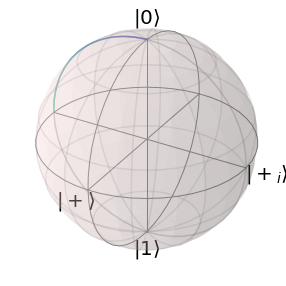

In [4]:
solver.set_optimization_parameters(.5 * control_amplitudes)
solver.plot_bloch_sphere()

We can verify that the system now does only a rotation of $\pi / 2$ with
the bloch sphere plot.

In [5]:
print("New enganglement fidelity: " + str(gate_infidelity.costs()))

New enganglement fidelity: 0.5000000000000002


Leakage is an additional problem in many qubit implementations. We refer to leakage when the qubit leaves the computational space. This can happen for example in some superconducting qubits, where the qubit is defined by the two lowest lying energy states of an anharmonic quantum oscillator and excitations to higher energy states must be considered as leakage.

Here we discuss the generic example of a qubit with an additional degree of freedom denoted by the ground $\vert g >$ and the excited state $\vert e >$. Any excitations to this degree of freedom can then be considered as leakage. The total Hilbert space is a product space of two two-dimensional Hilbert spaces. The first is the additional degree of freedom and the second one is our actual qubit. The computational space is spanned by the states without an excitation in the additional degree of freedom:

\begin{equation}
\mathcal{H}_c = \text{span} (\vert g, \uparrow >, \vert g, \downarrow>)
\end{equation}

Our control Hamiltonian now contains the operators:

\begin{align}
B_1 &= \text{Id} \otimes \sigma_x \\
B_1 &= \text{Id} \otimes \sigma_y
\end{align}

And as drift Hamiltonian we consider a constant interaction between the two systems:

\begin{align}
H_d = \delta \sigma_x \otimes \sigma_x
\end{align}

with some small interaction parameter $\delta$.

In [6]:
h_ctrl = [
    .5 * DenseOperator.pauli_0().kron(DenseOperator.pauli_x()),
    .5 * DenseOperator.pauli_0().kron(DenseOperator.pauli_y()),
]

delta = .1

h_drift = [
    delta * DenseOperator.pauli_x().kron(DenseOperator.pauli_x())
]

solver = SchroedingerSolver(
    h_drift=h_drift,
    h_ctrl=h_ctrl,
    tau=time_steps
)

When we now define the cost function, then we need to specify the computational states as a list of indices. The list of indices always correspond to basis states of our Hamiltonian. The computational states can only be basis states of our Hamiltonian and the indices decide which ones.

The gate infidelity is now calculated by first truncating the total unitary $U$ of the full system to the subsystem of computational states:

\begin{align}
U_{\text{trunc}}  = U\vert_{[0, 1]}
\end{align}

and subsequently calculating the gate infidelity:

\begin{equation}
I_e = 1 - \frac{1}{d^2}\vert \text{tr}\left( V^\dagger U_{\text{trunc}} \right)|^2.
\end{equation}

In [7]:
coherent_and_leakage_cost = OperationInfidelity(
    solver=solver,
    target=sigma_x,
    computational_states=[0, 1],
    map_to_closest_unitary=False
)
solver.set_optimization_parameters(control_amplitudes)
coherent_and_leakage_cost.costs()

0.009966711079378854

qopt supports the paradigm of the separation of error contributions. In this case, this means that qopt allows to separate leakage errors from coherent errors. Here we define a cost function for the coherent costs, which corrects leakage errors, by mapping the truncated unitary propagator to the closest unitary matrix before calculating the gate infidelity. The 'pure' leakage can be calculated as the distance from unitarity of the truncated propagator:

\begin{equation}
L = 1 - \frac{1}{d} \text{tr}\left( U_{\text{trunc}}^\dagger U_{\text{trunc}} \right).
\end{equation}

Please note that $d$ is still the dimension of the computational space.

In [8]:
coherent_cost = OperationInfidelity(
    solver=solver,
    target=sigma_x,
    computational_states=[0, 1],
    map_to_closest_unitary=True
)

leakage_cost_function = LeakageError(
    solver=solver,
    computational_states=[0, 1]
)



So for the perfect pulse we yield:

In [9]:
solver.set_optimization_parameters(control_amplitudes)
print('Systematic costs in the absence of leakage:')
print(coherent_cost.costs())
print('Pure leakage:')
print(leakage_cost_function.costs())

Systematic costs in the absence of leakage:
0.0
Pure leakage:
0.009966711079378854


And for the reduced pulse amplitude:

In [10]:
solver.set_optimization_parameters(.5 * control_amplitudes)
print('Systematic costs in the absence of leakage:')
print(coherent_cost.costs())
print('Pure leakage:')
print(leakage_cost_function.costs())

Systematic costs in the absence of leakage:
0.5000000000000004
Pure leakage:
0.00996671107937952
